In [1]:
from ucimlrepo import fetch_ucirepo 
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import export_graphviz
from sklearn.compose import ColumnTransformer
import graphviz
import re
import tensorflow as tf
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, roc_auc_score, roc_curve
)


# Загрузка данных
file_path = './adult 3 (1).csv'
df = pd.read_csv(file_path)
df = df.replace('?', pd.NA).dropna()
print(f"Размер датасета после удаления пропусков: {df.shape}\n")

Размер датасета после удаления пропусков: (45222, 15)



### Провести дескриптивный анализ

In [2]:
numeric_cols = ['age', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week']
df_analysis = df.copy()
df_analysis['income_num'] = (df_analysis['income'] == '>50K').astype(int)

for col in numeric_cols:
    print(f"\n--- {col.upper()} ---")
    desc = df_analysis[col].describe()
    print(desc)
    mode_value = df_analysis[col].mode()
    if not mode_value.empty:
        print(f"Мода: {mode_value.iloc[0]}")
    else:
        print(f"Мода не найдена.")
    # Асимметрия и эксцесс
    sk = skew(df_analysis[col])
    kt = kurtosis(df_analysis[col])
    print(f"Асимметрия (skewness): {sk:.3f} - {'правосторонняя' if sk > 0.5 else 'левосторонняя' if sk < -0.5 else 'умеренная'}")
    print(f"Эксцесс (kurtosis):   {kt:.3f} - {'островершинное' if kt > 3 else 'плосковершинное' if kt < 0 else 'нормальное'}")


--- AGE ---
count    45222.000000
mean        38.547941
std         13.217870
min         17.000000
25%         28.000000
50%         37.000000
75%         47.000000
max         90.000000
Name: age, dtype: float64
Мода: 36
Асимметрия (skewness): 0.533 - правосторонняя
Эксцесс (kurtosis):   -0.156 - плосковершинное

--- EDUCATIONAL-NUM ---
count    45222.000000
mean        10.118460
std          2.552881
min          1.000000
25%          9.000000
50%         10.000000
75%         13.000000
max         16.000000
Name: educational-num, dtype: float64
Мода: 9
Асимметрия (skewness): -0.311 - умеренная
Эксцесс (kurtosis):   0.635 - нормальное

--- CAPITAL-GAIN ---
count    45222.000000
mean      1101.430344
std       7506.430084
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      99999.000000
Name: capital-gain, dtype: float64
Мода: 0
Асимметрия (skewness): 11.789 - правосторонняя
Эксцесс (kurtosis):   150.135 - островершинное

--- CAPITAL-LOSS 

### Построение гистограмм

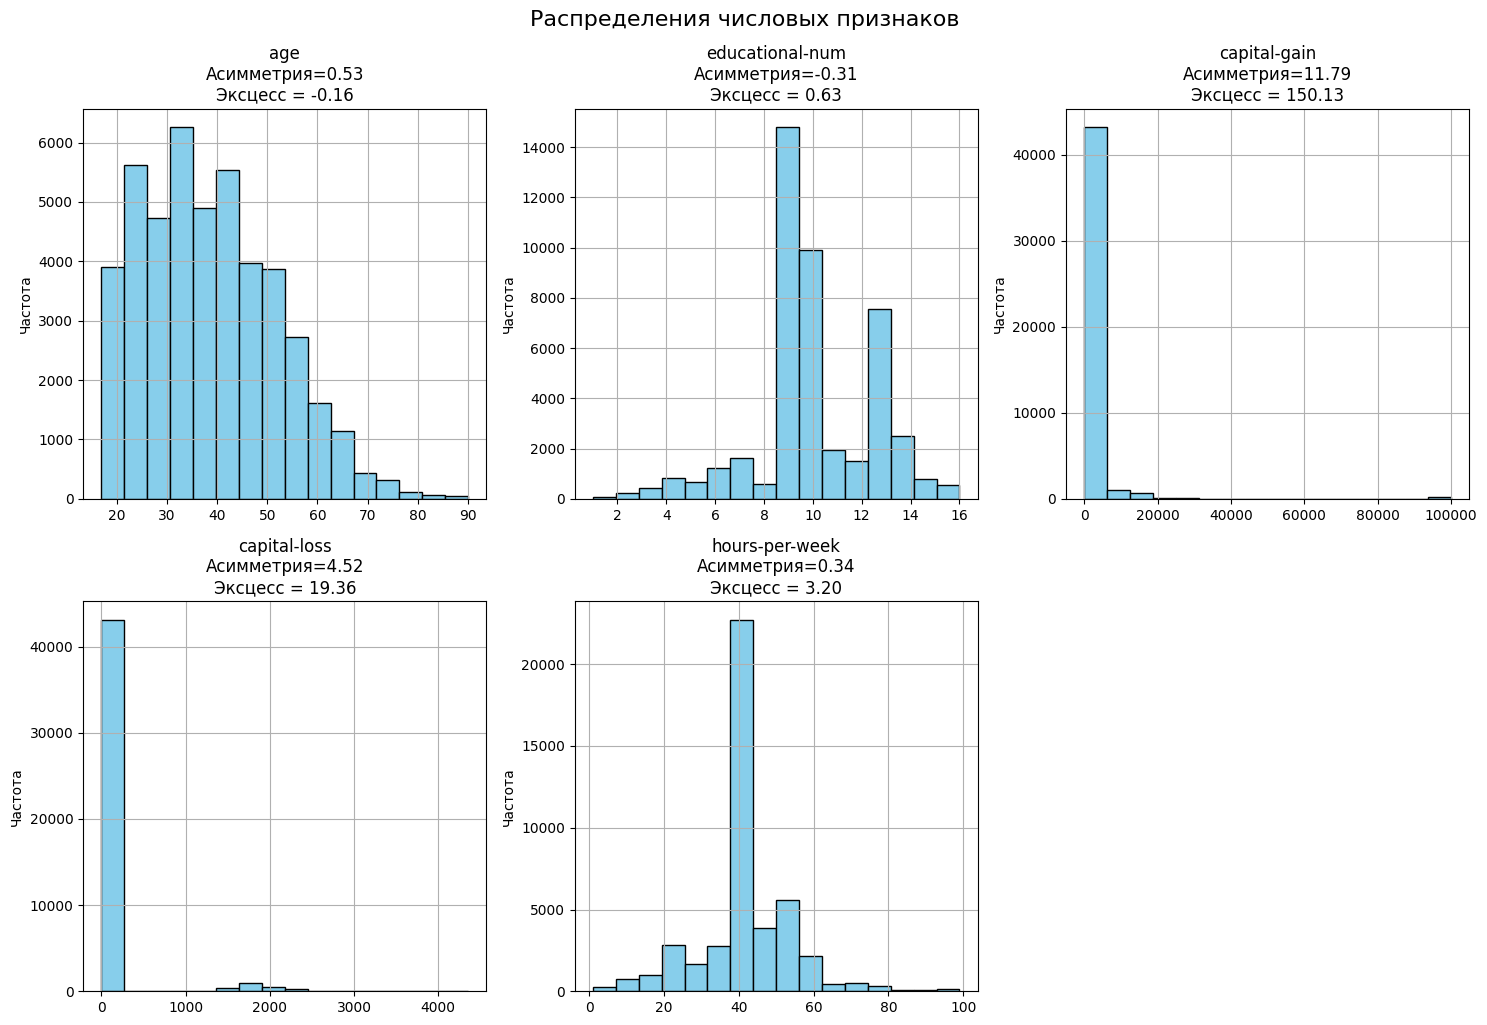

In [3]:
count_intervals = int(1 + math.log2(df_analysis.shape[0]))

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()
for i, col in enumerate(numeric_cols):
    df_analysis[col].hist(bins=count_intervals, ax=axes[i], color='skyblue', edgecolor='black')
    axes[i].set_title(f'{col}\nАсимметрия={skew(df_analysis[col]):.2f}\nЭксцесс = {kurtosis(df_analysis[col]):.2f}')
    axes[i].set_ylabel('Частота')
axes[-1].axis('off')
plt.tight_layout()
plt.suptitle("Распределения числовых признаков", y=1.02, fontsize=16)
plt.show()

### Анализ категориальных данных (распределение объектов по классам и для с доходом >50K в каждой категории)

In [4]:
categorical_cols = ['income','workclass', 'education', 'marital-status', 'occupation', 
                    'relationship', 'race', 'gender', 'native-country']

df['income_num'] = (df['income'] == '>50K').astype(int)

for col in categorical_cols:
    print(f"\n--- {col.upper()} ---")
    
    # 1. Распределение категорий (частота в %)
    dist = df[col].value_counts(normalize=True) * 100
    print("Распределение категорий (% от общего числа):")
    for cat, pct in dist.items():
        print(f"  {cat}: {pct:.2f}%")
    
    # 2. Доля >50K в каждой категории
    income_by_cat = df.groupby(col)['income_num'].mean().sort_values(ascending=False)
    print("\nДоля с доходом >50K в каждой категории:")
    for cat, prop in income_by_cat.items():
        print(f"  {cat}: {prop:.2%}")
    
    print("-" * 50)


--- INCOME ---
Распределение категорий (% от общего числа):
  <=50K: 75.22%
  >50K: 24.78%

Доля с доходом >50K в каждой категории:
  >50K: 100.00%
  <=50K: 0.00%
--------------------------------------------------

--- WORKCLASS ---
Распределение категорий (% от общего числа):
  Private: 73.65%
  Self-emp-not-inc: 8.39%
  Local-gov: 6.86%
  State-gov: 4.30%
  Self-emp-inc: 3.64%
  Federal-gov: 3.11%
  Without-pay: 0.05%

Доля с доходом >50K в каждой категории:
  Self-emp-inc: 55.41%
  Federal-gov: 39.05%
  Local-gov: 29.52%
  Self-emp-not-inc: 27.90%
  State-gov: 26.72%
  Private: 21.77%
  Without-pay: 9.52%
--------------------------------------------------

--- EDUCATION ---
Распределение категорий (% от общего числа):
  HS-grad: 32.69%
  Some-college: 21.89%
  Bachelors: 16.74%
  Masters: 5.56%
  Assoc-voc: 4.33%
  11th: 3.58%
  Assoc-acdm: 3.33%
  10th: 2.70%
  7th-8th: 1.82%
  Prof-school: 1.74%
  9th: 1.49%
  12th: 1.28%
  Doctorate: 1.20%
  5th-6th: 0.99%
  1st-4th: 0.49%
  Pre

### Аргументировать выбор методов решения задачи классификации по результатам описания датасета.
Анализ датасета показал, что задача прогнозирования годового дохода (≤50K / >50K) обладает рядом характерных особенностей, определяющих выбор методов машинного обучения. Во-первых, распределение целевой переменной демонстрирует умеренный дисбаланс классов: доля объектов с доходом ≤50K составляет 75.2%, что требует применения методов, устойчивых к несбалансированности, либо использования взвешивания классов. Во-вторых, признаковое пространство включает как числовые (возраст, количество рабочих часов, уровень образования, капитальный доход и убыток), так и категориальные переменные (профессия, социальная роль, тип занятости), причём последние содержат значимую предсказательную информацию — например, доля лиц с доходом >50K варьируется от 1.4% (дошкольное образование) до 75.4% (профессиональная школа).

Кроме того, числовые признаки существенно отклоняются от нормального распределения: наблюдается асимметрия и высокие заначения эксцесс, а такие переменные, как capital-gain и capital-loss, являются сильно разреженными (более 90% нулевых значений). Это исключает применение методов, предполагающих нормальность распределений или линейные зависимости.

С учётом перечисленных особенностей для решения задачи были выбраны два метода: дерево решений и полносвязная нейронная сеть. Дерево решений было принято в качестве первого метода, поскольку оно эффективно работает с табличными данными смешанного типа, не требует нормализации признаков, устойчиво к выбросам и нарушению нормальности, а также обеспечивает высокую интерпретируемость — что особенно важно при анализе социально-экономических факторов, влияющих на доход. Нейронная сеть использована в качестве второго метода для оценки потенциала нелинейного моделирования сложных взаимодействий между признаками. Однако её применение требует предобработки данных: One-Hot кодирования категориальных переменных и масштабирования числовых признаков. 

### Провести отбор наиболее информативных признаков. 

In [5]:
print("\nКорреляция числовых признаков с доходом (>50K):")
corr_with_target = df_analysis[numeric_cols + ['income_num']].corr()['income_num'].abs().sort_values(ascending=False)
print(corr_with_target.drop('income_num'))

# 4.2 Категориальные: максимальная доля >50K и размах
print("\nМаксимальная доля >50K в категориях:")
cat_strength = {}
for col in categorical_cols:
    max_prop = df_analysis.groupby(col)['income_num'].mean().max()
    min_prop = df_analysis.groupby(col)['income_num'].mean().min()
    range_prop = max_prop - min_prop
    cat_strength[col] = {'max': max_prop, 'range': range_prop}
    print(f"{col:18s}: макс. {max_prop:.2%} | размах {range_prop:.2%}")

# Сортируем по размаху (насколько категория разделяет классы)
cat_rank = sorted(cat_strength.items(), key=lambda x: x[1]['range'], reverse=True)
print("\nРанжирование категориальных признаков по размаху доли >50K:")
for col, metrics in cat_rank[:]:
    print(f"{col}: размах = {metrics['range']:.2%}")


Корреляция числовых признаков с доходом (>50K):
educational-num    0.332800
age                0.237040
hours-per-week     0.227199
capital-gain       0.221034
capital-loss       0.148687
Name: income_num, dtype: float64

Максимальная доля >50K в категориях:
income            : макс. 100.00% | размах 100.00%
workclass         : макс. 55.41% | размах 45.88%
education         : макс. 75.41% | размах 74.03%
marital-status    : макс. 45.42% | размах 40.62%
occupation        : макс. 47.91% | размах 46.62%
relationship      : макс. 48.59% | размах 47.00%
race              : макс. 28.32% | размах 16.14%
gender            : макс. 31.25% | размах 19.89%
native-country    : макс. 45.45% | размах 45.45%

Ранжирование категориальных признаков по размаху доли >50K:
income: размах = 100.00%
education: размах = 74.03%
relationship: размах = 47.00%
occupation: размах = 46.62%
workclass: размах = 45.88%
native-country: размах = 45.45%
marital-status: размах = 40.62%
gender: размах = 19.89%
race: разма

Наиболее информативными признаны признаки, демонстрирующие наибольшую способность разделять классы по доходу:

Среди числовых — educational-num (корреляция 0.33), age и hours-per-week (оба ~0.23), а также capital-gain и capital-loss, несмотря на разреженность.

Среди категориальных — education (размах 74%), relationship (47%), occupation (46.6%) и workclass (45.9%).

Признаки race, gender и native-country исключены: первые два — из-за слабой предсказательной силы, последний — из-за статистической ненадёжности (крайний дисбаланс категорий).
marital-status исключён как дублирующий более информативный признак relationship.

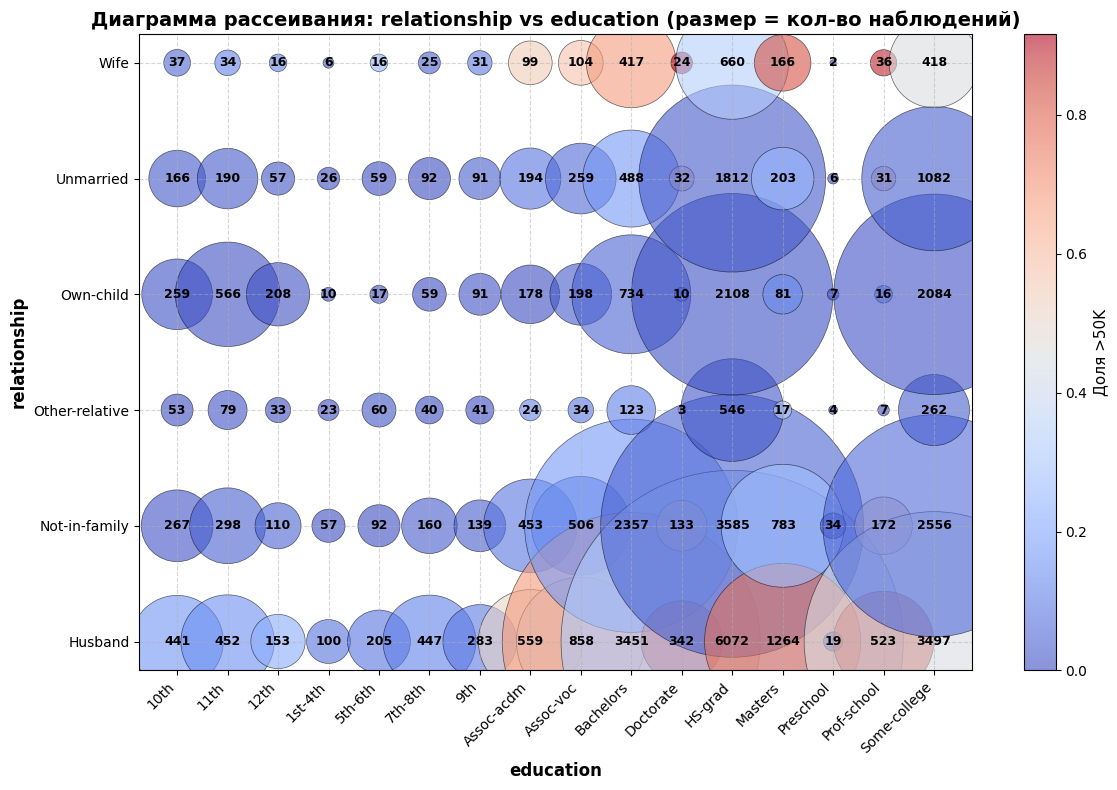

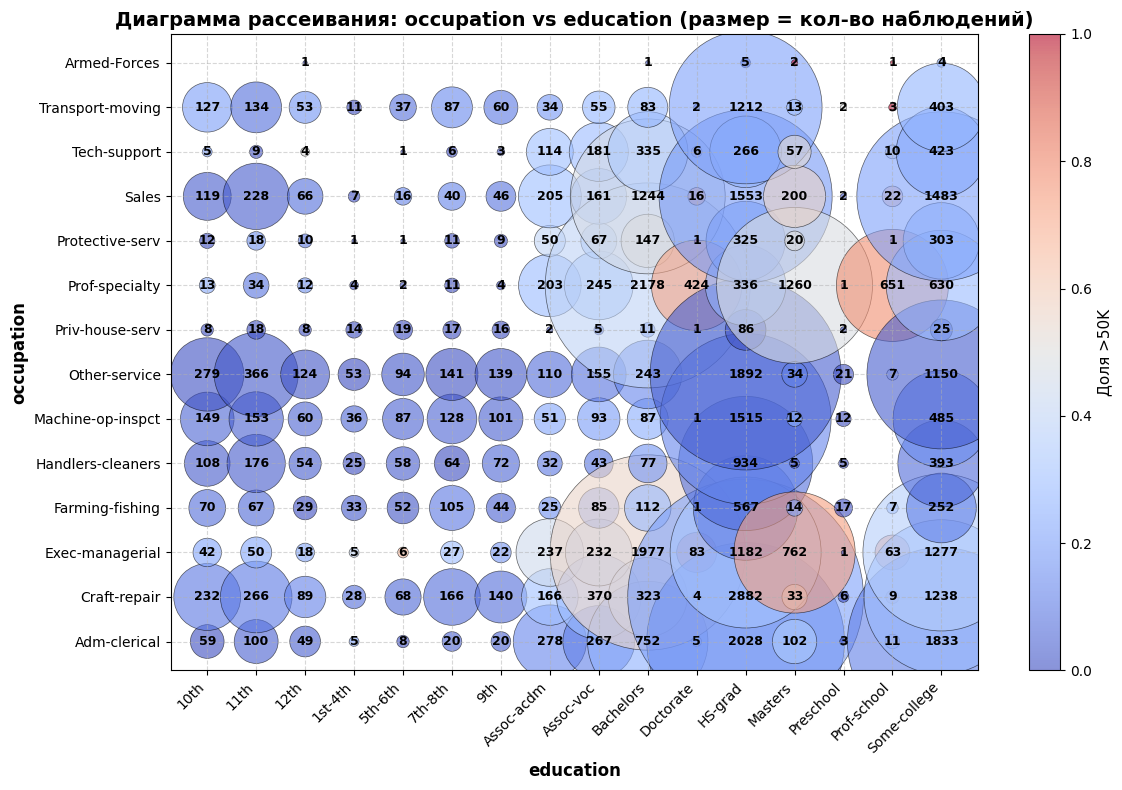

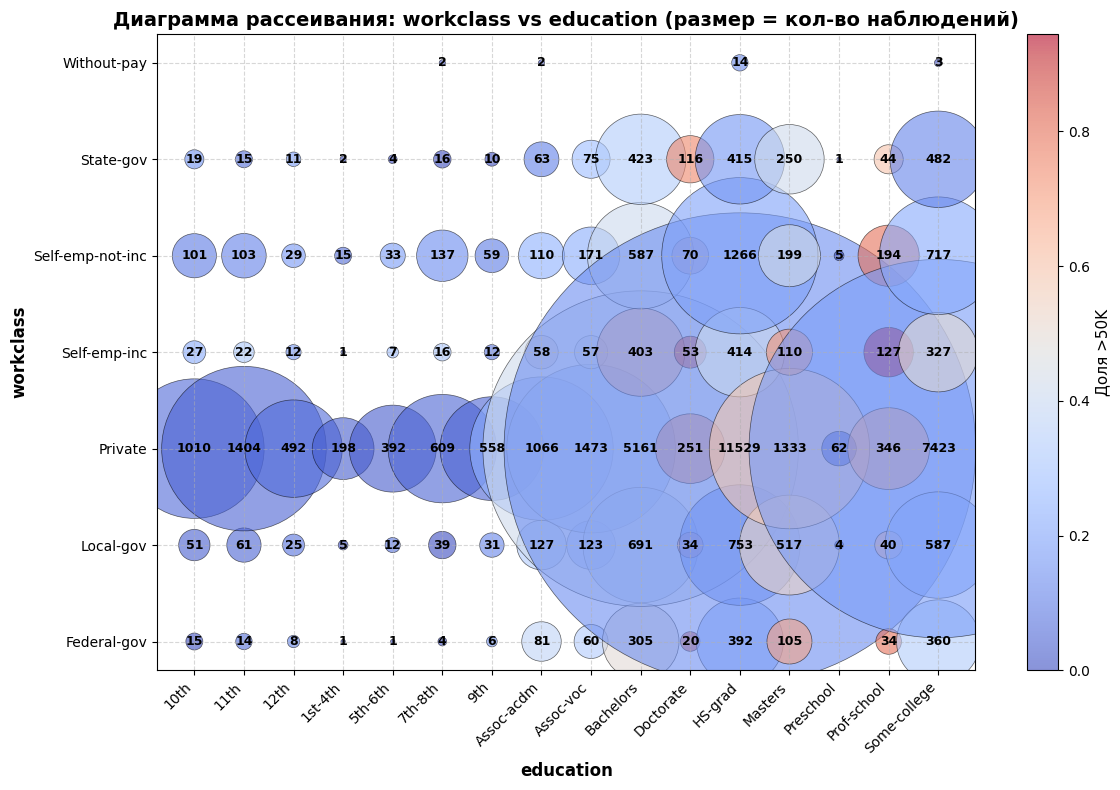

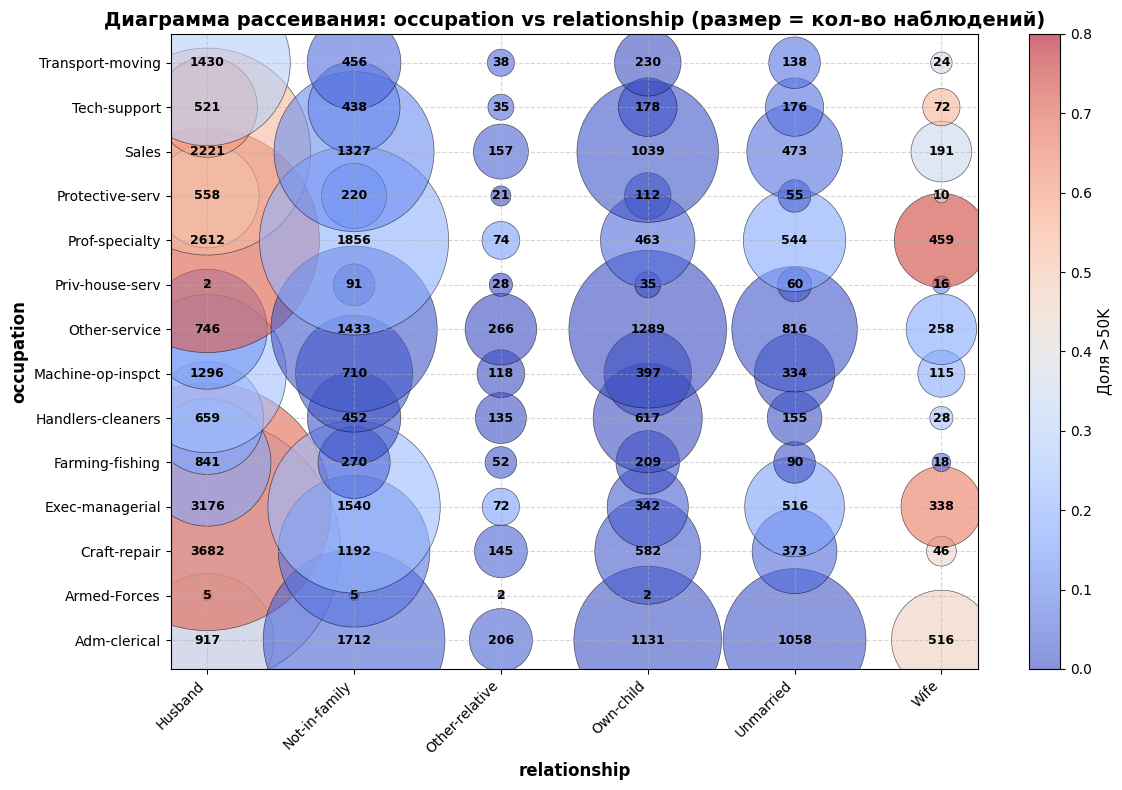

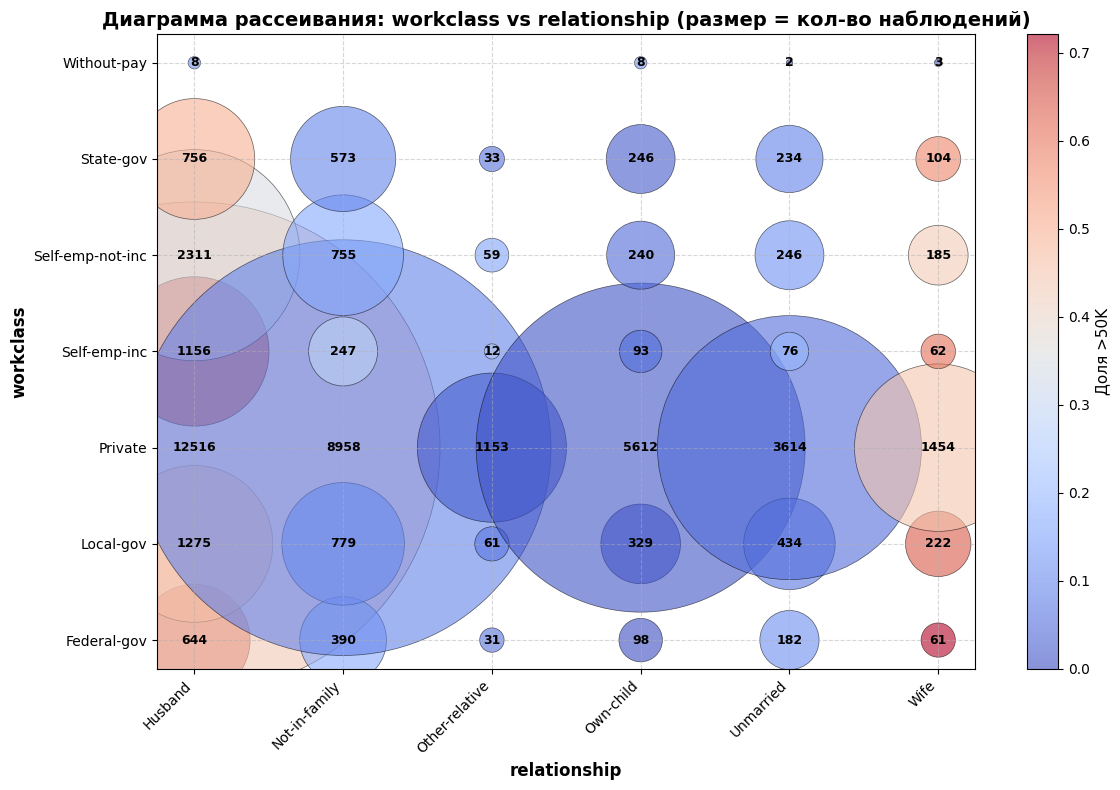

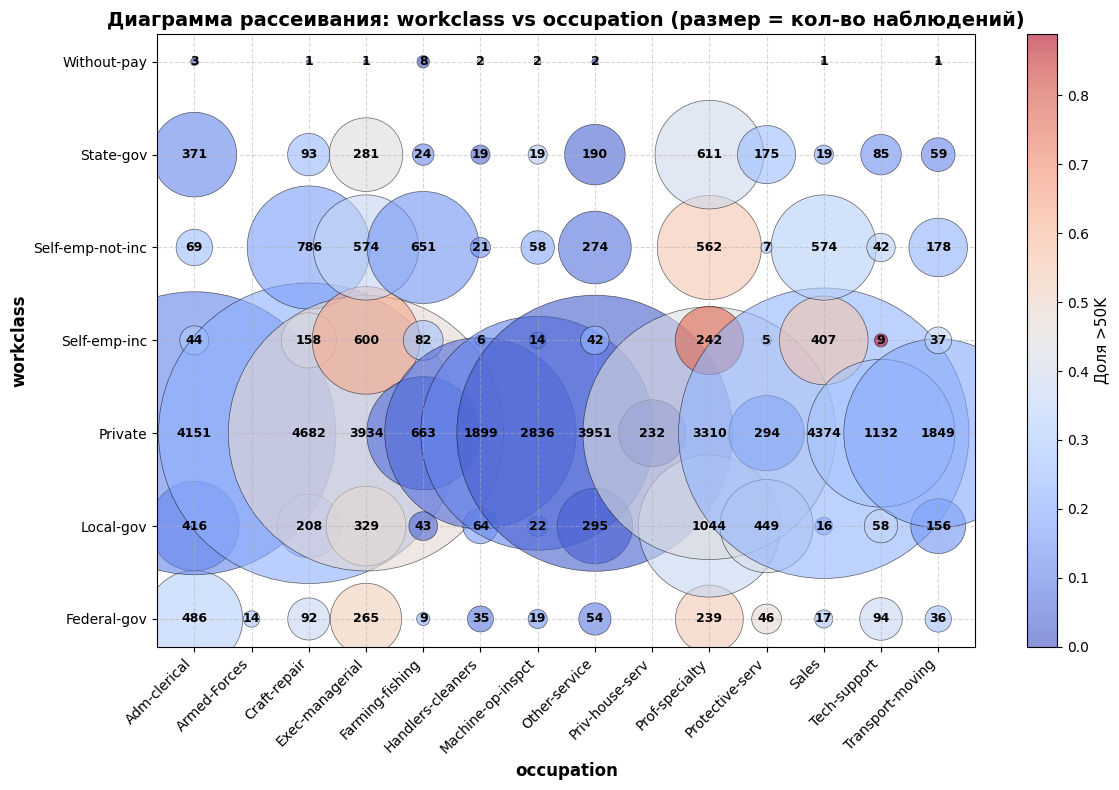

In [6]:
df_plot = df.copy()
df_plot['income_binary'] = (df_plot['income'] == '>50K').astype(int)

# Выберем пары признаков (ваш список)
numeric_pairs = [
    ('education', 'relationship'),
    ('education', 'occupation'),
    ('education', 'workclass'),
    ('relationship', 'occupation'),
    ('relationship', 'workclass'),
    ('occupation', 'workclass'),
]

for x_col, y_col in numeric_pairs:
    # Сгруппируем данные и посчитаем количество точек в каждой ячейке
    grouped = df_plot.groupby([x_col, y_col]).agg({
        'income_binary': ['count', 'mean']  # количество и среднее (для цвета)
    }).reset_index()
    
    grouped.columns = [x_col, y_col, 'count', 'mean_income']
    
    # Создаём фигуру
    plt.figure(figsize=(12, 8))
    
    # Нормализуем размер точек для лучшего визуального восприятия
    sizes = grouped['count'] * 10  # масштабируем, чтобы точки были заметны
    
    scatter = plt.scatter(
        grouped[x_col],
        grouped[y_col],
        c=grouped['mean_income'],  # цвет зависит от среднего дохода (>50K)
        s=sizes,                   # размер зависит от количества наблюдений
        cmap='coolwarm',
        alpha=0.6,
        edgecolors='black',
        linewidth=0.5
    )
    
    # Добавим аннотации с количеством наблюдений
    for i in range(len(grouped)):
        plt.text(
            grouped.iloc[i][x_col],
            grouped.iloc[i][y_col],
            str(grouped.iloc[i]['count']),
            horizontalalignment='center',
            verticalalignment='center',
            fontsize=9,
            color='black',
            weight='bold'
        )

    plt.xlabel(x_col, fontsize=12, fontweight='bold')
    plt.ylabel(y_col, fontsize=12, fontweight='bold')
    plt.title(f'Диаграмма рассеивания: {y_col} vs {x_col} (размер = кол-во наблюдений)', fontsize=14, fontweight='bold')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(fontsize=10)

    # Легенда для цвета
    cbar = plt.colorbar(scatter)
    cbar.set_label('Доля >50K', fontsize=11)

    plt.tight_layout()
    plt.show()

In [7]:
le_income = LabelEncoder()
le_relationship = LabelEncoder()
le_workclass = LabelEncoder()
le_education = LabelEncoder()
le_occupation = LabelEncoder()

df['income_num'] = le_income.fit_transform(df['income'])
df['relationship_num'] = le_relationship.fit_transform(df['relationship'])
df['workclass_num'] = le_workclass.fit_transform(df['workclass'])
df['education_num'] = le_education.fit_transform(df['education'])
df['occupation_num'] = le_occupation.fit_transform(df['occupation'])


columns_to_drop = ['fnlwgt', 'native-country', 
                    'marital-status', 
                   'race', 'gender', 
                   'income', 'relationship', 'workclass', 'education', 'occupation']
df = df.drop(columns=columns_to_drop)

print("Столбцы после удаления:")
print(df.columns.tolist())

Столбцы после удаления:
['age', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'income_num', 'relationship_num', 'workclass_num', 'education_num', 'occupation_num']


### Дерево решений

=== Метрики для обучающего множества ===
Accuracy: 0.8113
Precision (macro): 0.7510
Precision (micro): 0.8113
Recall (macro): 0.7817
Recall (micro): 0.8113
F1-score (macro): 0.7630
F1-score (micro): 0.8113
AUC: 0.8494
------------------------------
=== Метрики для тестового множества ===
Accuracy: 0.8118
Precision (macro): 0.7485
Precision (micro): 0.8118
Recall (macro): 0.7805
Recall (micro): 0.8118
F1-score (macro): 0.7609
F1-score (micro): 0.8118
AUC: 0.8510
------------------------------


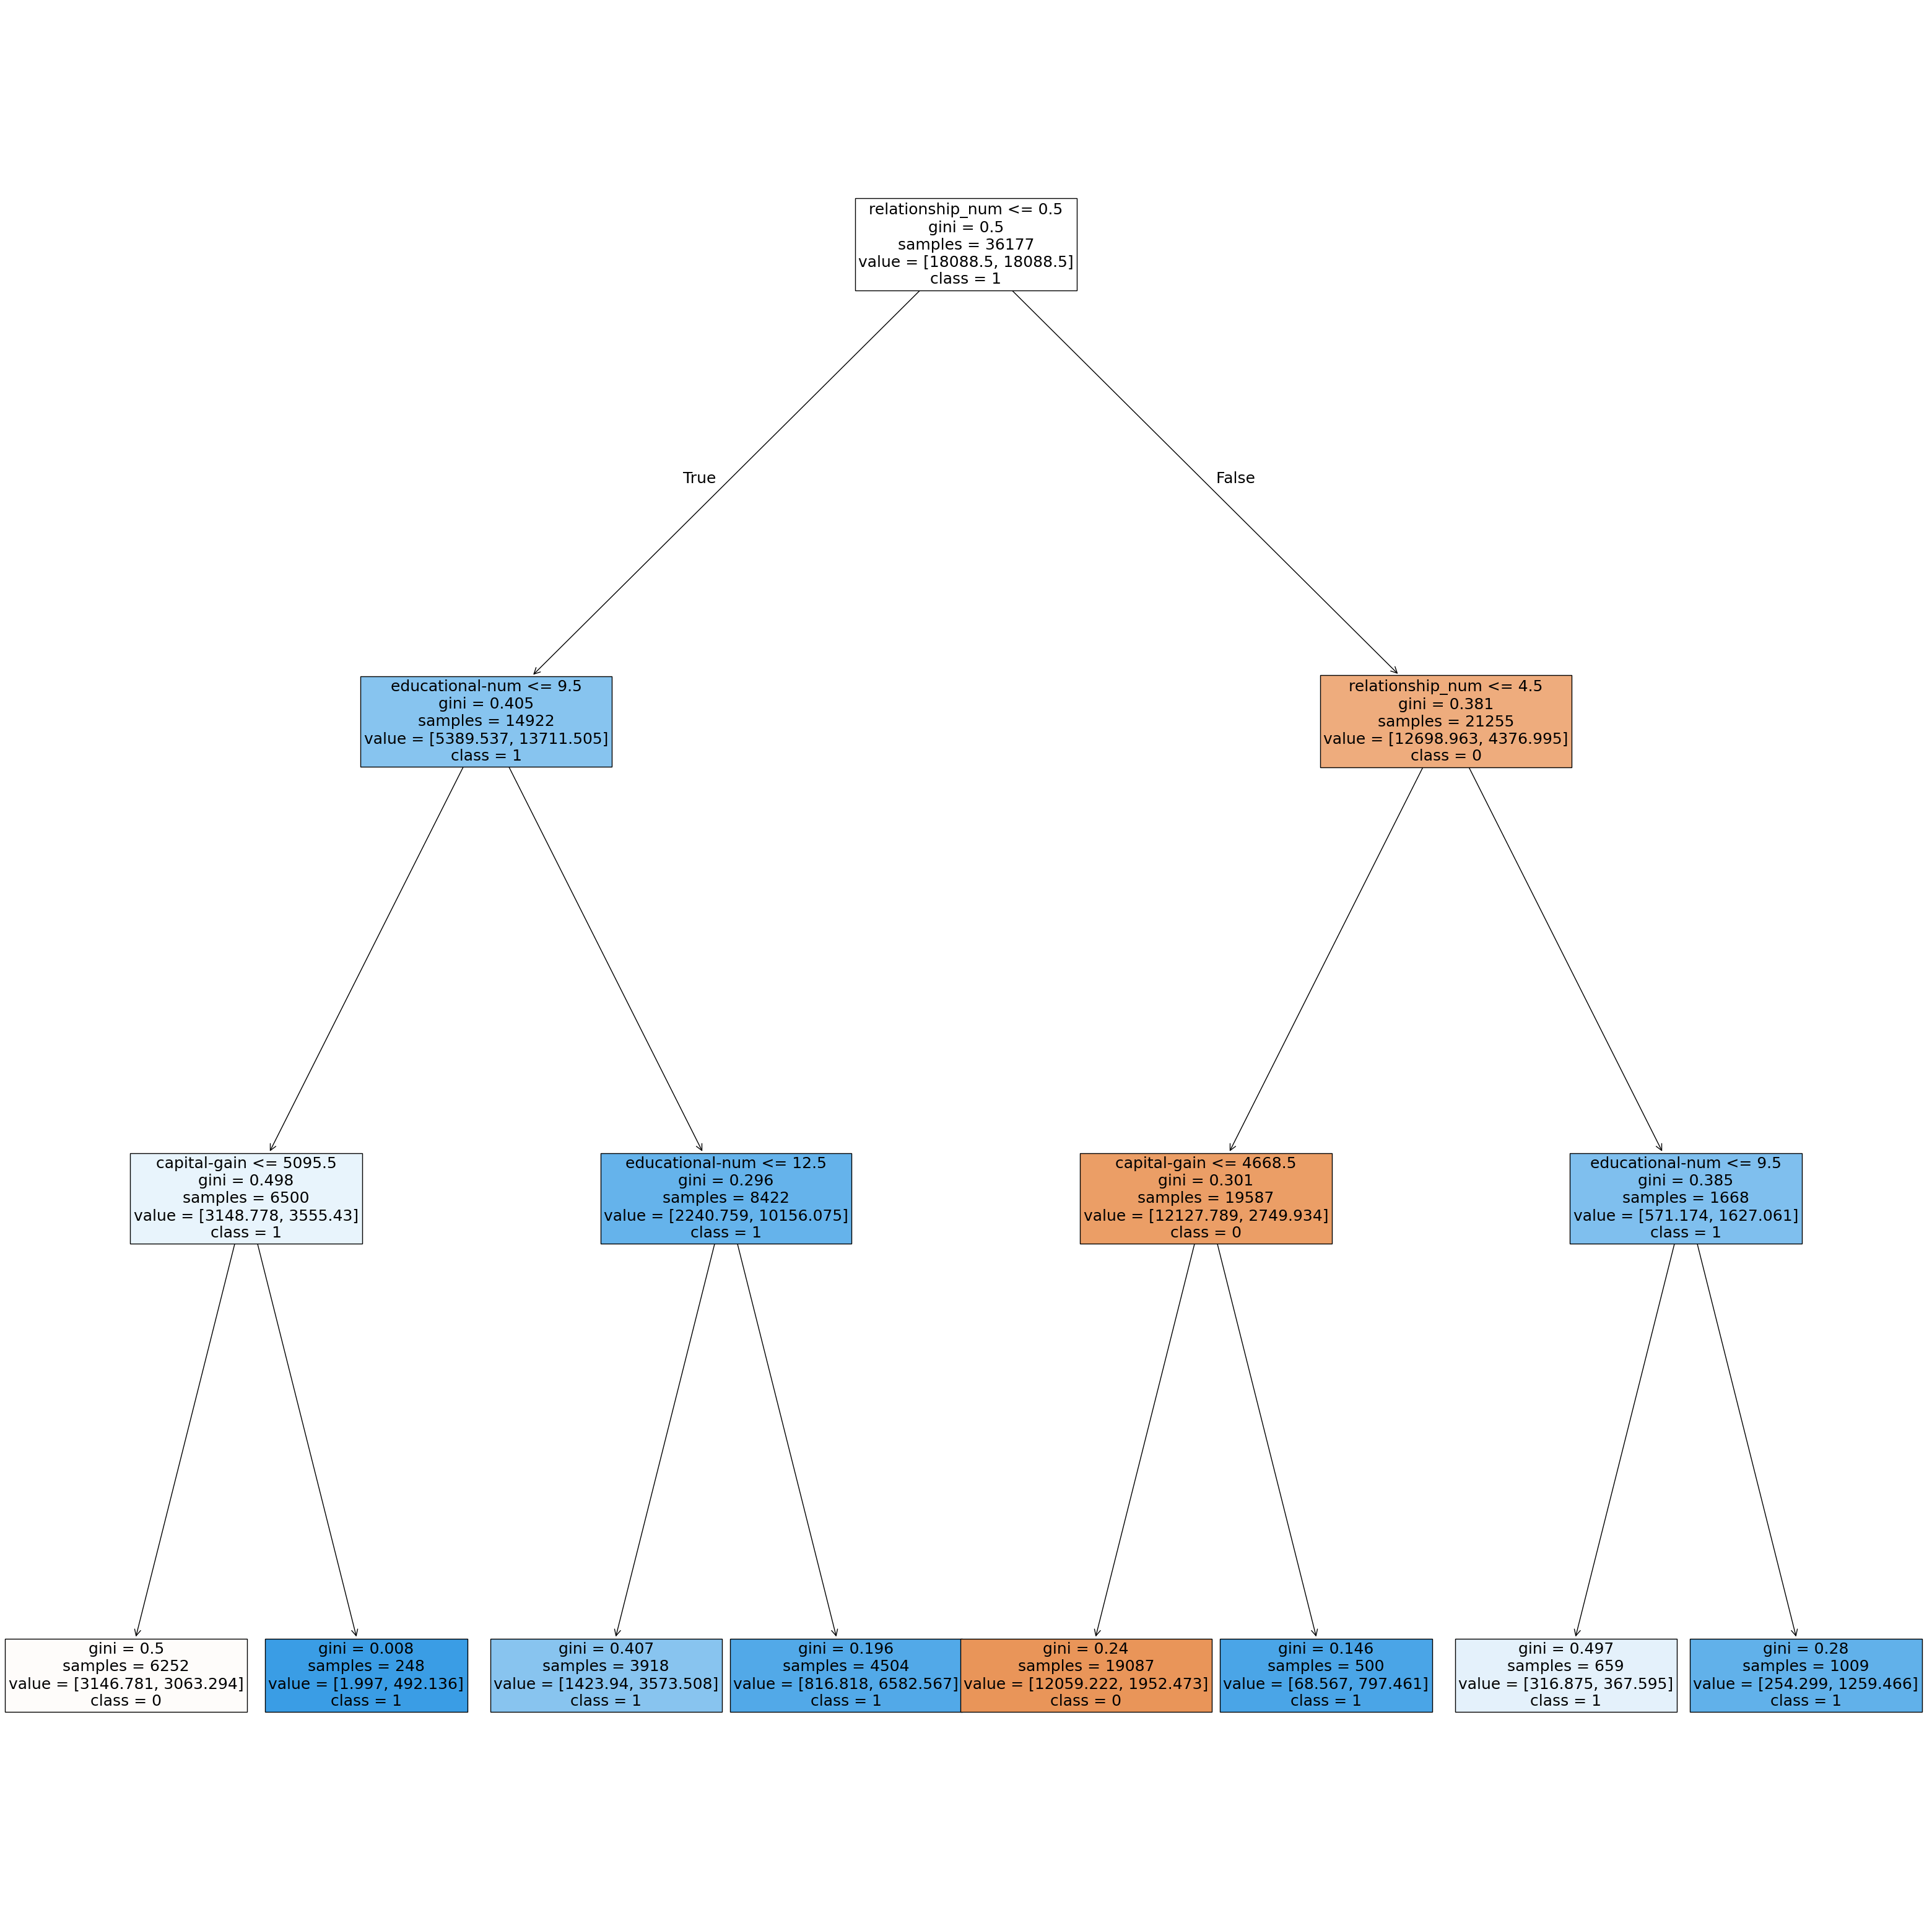

In [8]:
X = df.drop('income_num', axis=1)  # все столбцы, кроме целевой
y = df['income_num']

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создание модели дерева решений
clf = DecisionTreeClassifier(
    random_state=42,
    max_depth=3, 
    class_weight='balanced',
    min_samples_split=10,  # минимум 10 образцов для разбиения
    min_samples_leaf=5,    # минимум 5 в листе
    criterion='gini'       
)

# Обучение модели
clf.fit(X_train, y_train)

y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

# Предсказания вероятностей (для AUC)
y_train_proba = clf.predict_proba(X_train)[:, 1]
y_test_proba = clf.predict_proba(X_test)[:, 1]

# Определение метрик
def calculate_metrics(y_true, y_pred, y_proba, dataset_name):
    print(f"=== Метрики для {dataset_name} ===")
    accuracy = accuracy_score(y_true, y_pred)
    precision_macro = precision_score(y_true, y_pred, average='macro', zero_division=0)
    precision_micro = precision_score(y_true, y_pred, average='micro', zero_division=0)
    recall_macro = recall_score(y_true, y_pred, average='macro', zero_division=0)
    recall_micro = recall_score(y_true, y_pred, average='micro', zero_division=0)
    f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
    f1_micro = f1_score(y_true, y_pred, average='micro', zero_division=0)
    # AUC рассчитывается только для бинарной классификации
    auc = roc_auc_score(y_true, y_proba)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (macro): {precision_macro:.4f}")
    print(f"Precision (micro): {precision_micro:.4f}")
    print(f"Recall (macro): {recall_macro:.4f}")
    print(f"Recall (micro): {recall_micro:.4f}")
    print(f"F1-score (macro): {f1_macro:.4f}")
    print(f"F1-score (micro): {f1_micro:.4f}")
    print(f"AUC: {auc:.4f}")
    print("-" * 30)

# Вычисление метрик
calculate_metrics(y_train, y_train_pred, y_train_proba, "обучающего множества")
calculate_metrics(y_test, y_test_pred, y_test_proba, "тестового множества")

plt.figure(figsize=(40, 40))
plot_tree(clf,
          filled=True,
          fontsize=18,
          max_depth=3,
          feature_names=X.columns,
          class_names=clf.classes_.astype(str),  # если классы числовые, преобразуем в строки
          )
plt.show()

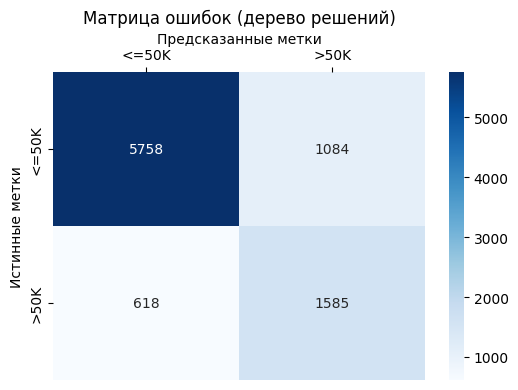

In [9]:
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le_income.classes_, yticklabels=le_income.classes_)
plt.xticks(rotation=0)  # Убираем поворот (если есть)
plt.gca().xaxis.tick_top()  # Перемещаем ось X наверх
plt.gca().xaxis.set_label_position('top')  # Подпись оси X тоже наверх
plt.xlabel('Предсказанные метки')
plt.ylabel('Истинные метки')
plt.title('Матрица ошибок (дерево решений)')
plt.show()

### Метод нейронных сетей

Сеть, определённая с помощью Sequential и состоящая из слоёв Dense, характерна для полносвязной архитектуры:

Каждый нейрон в слое Dense(64, ...) соединён со всеми нейронами предыдущего слоя (в данном случае — с выходами предыдущего слоя признаков после preprocessor).
Каждый нейрон в слое Dense(32, ...) соединён со всеми нейронами предыдущего слоя (Dense(64, ...)).
Наконец, выходной слой Dense(1, ...) также соединён со всеми нейронами предыдущего слоя (Dense(32, ...)).
Слои Dropout не изменяют архитектуру на "разреженную" — они просто случайным образом "отключают" часть нейронов во время обучения для борьбы с переобучением, но структура полносвязности сохраняется.

c:\Документы\НГТУ\7 семестр\Методы анализа данных\лабы\МАД лаба 2\venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


=== Метрики для обучающего множества (Нейронная сеть) ===
Accuracy: 0.8766
Precision (macro): 0.8520
Precision (micro): 0.8766
Recall (macro): 0.8034
Recall (micro): 0.8766
F1-score (macro): 0.8233
F1-score (micro): 0.8766
AUC: 0.9355
----------------------------------------
=== Метрики для тестового множества (Нейронная сеть) ===
Accuracy: 0.8753
Precision (macro): 0.8497
Precision (micro): 0.8753
Recall (macro): 0.7955
Recall (micro): 0.8753
F1-score (macro): 0.8173
F1-score (micro): 0.8753
AUC: 0.9280
----------------------------------------


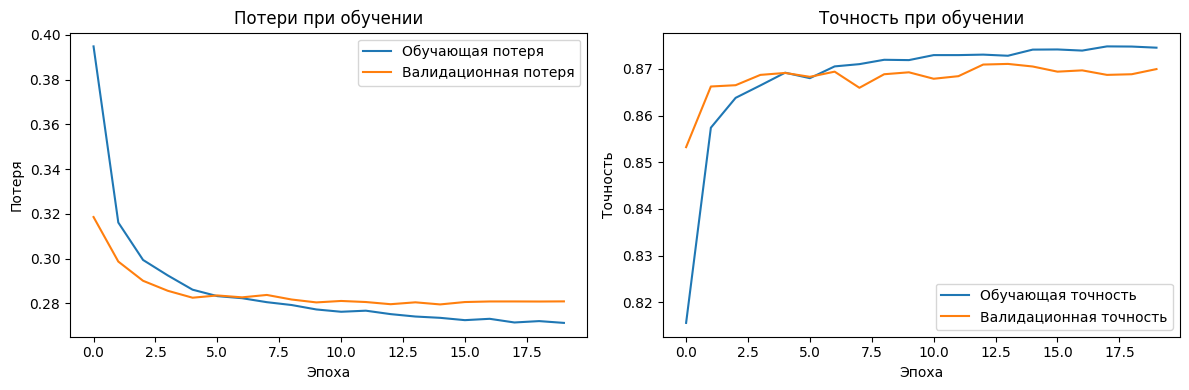

In [10]:
X = df.drop('income_num', axis=1)  # все столбцы, кроме целевой
y = df['income_num']

numeric_columns = ['age', 'hours-per-week']
all_columns = X.columns.tolist() 
categorical_columns = [col for col in all_columns if col not in numeric_columns]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
    ])

X_processed = preprocessor.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

# 3. Построение модели
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 4. Обучение модели (без вывода шагов)
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=128,
    validation_split=0.2,
    verbose=0  # Убираем вывод шагов
)

# 5. Предсказания
# Для вероятностей используем predict (без порога)
y_train_proba_raw = model.predict(X_train, verbose=0)
y_test_proba_raw = model.predict(X_test, verbose=0)

# Для бинарных предсказаний используем порог 0.5
y_train_pred = (y_train_proba_raw > 0.5).astype(int)
y_test_pred = (y_test_proba_raw > 0.5).astype(int)

# Извлечение скаляров из массивов (для бинарной классификации с 1 нейроном на выходе)
y_train_proba = y_train_proba_raw.flatten()
y_test_proba = y_test_proba_raw.flatten()

# Функция для вычисления метрик
def calculate_metrics_nn(y_true, y_pred, y_proba, dataset_name):
    print(f"=== Метрики для {dataset_name} (Нейронная сеть) ===")
    accuracy = accuracy_score(y_true, y_pred)
    precision_macro = precision_score(y_true, y_pred, average='macro', zero_division=0)
    precision_micro = precision_score(y_true, y_pred, average='micro', zero_division=0)
    recall_macro = recall_score(y_true, y_pred, average='macro', zero_division=0)
    recall_micro = recall_score(y_true, y_pred, average='micro', zero_division=0)
    f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
    f1_micro = f1_score(y_true, y_pred, average='micro', zero_division=0)
    # AUC рассчитывается только для бинарной классификации
    auc = roc_auc_score(y_true, y_proba)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (macro): {precision_macro:.4f}")
    print(f"Precision (micro): {precision_micro:.4f}")
    print(f"Recall (macro): {recall_macro:.4f}")
    print(f"Recall (micro): {recall_micro:.4f}")
    print(f"F1-score (macro): {f1_macro:.4f}")
    print(f"F1-score (micro): {f1_micro:.4f}")
    print(f"AUC: {auc:.4f}")
    print("-" * 40)

# Вычисление метрик
calculate_metrics_nn(y_train, y_train_pred, y_train_proba, "обучающего множества")
calculate_metrics_nn(y_test, y_test_pred, y_test_proba, "тестового множества")


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Обучающая потеря')
plt.plot(history.history['val_loss'], label='Валидационная потеря')
plt.title('Потери при обучении')
plt.xlabel('Эпоха')
plt.ylabel('Потеря')
plt.legend()

# Построение графиков точности
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Обучающая точность')
plt.plot(history.history['val_accuracy'], label='Валидационная точность')
plt.title('Точность при обучении')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.legend()

plt.tight_layout()
plt.show()

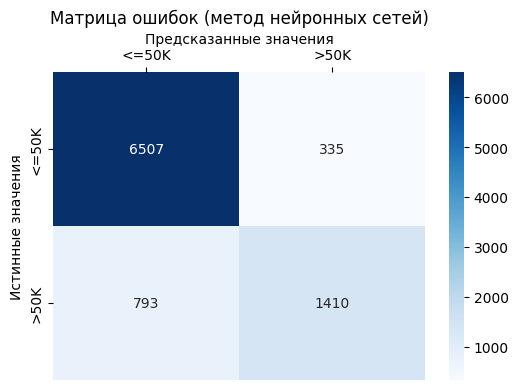

In [11]:
# Матрица ошибок
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['<=50K', '>50K'], yticklabels=['<=50K', '>50K'])
plt.xticks(rotation=0)  # Убираем поворот (если есть)
plt.gca().xaxis.tick_top()  # Перемещаем ось X наверх
plt.gca().xaxis.set_label_position('top')  # Подпись оси X тоже наверх
plt.xlabel('Предсказанные значения')
plt.ylabel('Истинные значения')
plt.title('Матрица ошибок (метод нейронных сетей)')
plt.show()

### Сравнение моделей

#### 1. Accuracy
- **Дерево**: 0.8118
- **НС**: 0.8735
- **Разница**: 0.0617

**Вывод**: Нейронная сеть демонстрирует более высокую общую точность — она правильно классифицирует на 6.17% больше объектов из всей тестовой выборки.

#### 2. Precision (macro)
- **Дерево**: 0.7485
- **НС**: 0.8545
- **Разница**: 0.1060

**Вывод**: Нейронная сеть показывает значительно более высокую точность предсказаний — на 10.6% выше, чем у дерева. Это указывает на лучшее качество работы с обоими классами одновременно.

#### 3. Recall (macro)
- **Дерево**: 0.7805
- **НС**: 0.7844
- **Разница**: 0.0039

**Вывод**: Нейронная сеть показывает почти идентичную полноту, уступая дереву менее чем на 0.4%. Это означает, что способность находить истинные объекты в обоих классах практически одинакова.

#### 4. F1-score (macro)
- **Дерево**: 0.7609
- **НС**: 0.8107
- **Разница**: 0.0498

**Вывод**: Нейронная сеть обеспечивает лучший баланс между precision и recall — F1 выше на 4.98%, что свидетельствует о более сбалансированной работе с обоими классами.

#### 5. AUC
- **Дерево**: 0.8510
- **НС**: 0.9278
- **Разница**: 0.0768

**Вывод**: Нейронная сеть значительно лучше ранжирует объекты по вероятности принадлежности к классу — AUC выше на 0.077, что соответствует переходу из категории «хорошая» (0.8–0.9) в «отличная» (0.9–1.0).

#### Вывод
Таким образом, нейронная сеть демонстрирует превосходство как в общей точности, так и в сбалансированности работы с обоими классами, что подтверждается всеми стандартными метриками оценки качества бинарной классификации.